In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv('train.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
dev_data = pd.read_csv('dev.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])
test_data = pd.read_csv('test.txt', sep='\t', header=None, names=['pmid', 'label', 'txt'])

<BarContainer object of 5 artists>

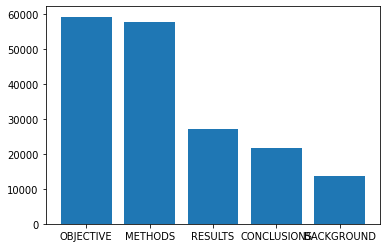

In [3]:
labels = train_data['label'].unique()

plt.bar(labels, train_data['label'].value_counts())

In [4]:
train_data['txt']

0         To investigate the efficacy of 6 weeks of dail...
1         A total of 125 patients with primary knee OA w...
2         Outcome measures included pain reduction and i...
3         Pain was assessed using the visual analog pain...
4         Secondary outcome measures included the Wester...
                                ...                        
180035    For the absolute change in percent atheroma vo...
180036    For PAV , a significantly greater percentage o...
180037    Both strategies had acceptable side effect pro...
180038    Compared with standard statin monotherapy , th...
180039    ( Plaque Regression With Cholesterol Absorptio...
Name: txt, Length: 180040, dtype: object

In [8]:
import spacy
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

nlp = spacy.load('en_core_web_sm')

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/changhyun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/changhyun/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
